In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
import torchvision.transforms.functional as F

In [2]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Класс 'Leegaardiella_ovalis': 10 изображений
Класс 'Mesodinium_sp': 676 изображений
Класс 'amoeba': 14 изображений

Распределение классов:
  Mesodinium_sp: 676 изображений
  amoeba: 14 изображений
  Leegaardiella_ovalis: 10 изображений

Всего изображений: 700
Количество классов: 3


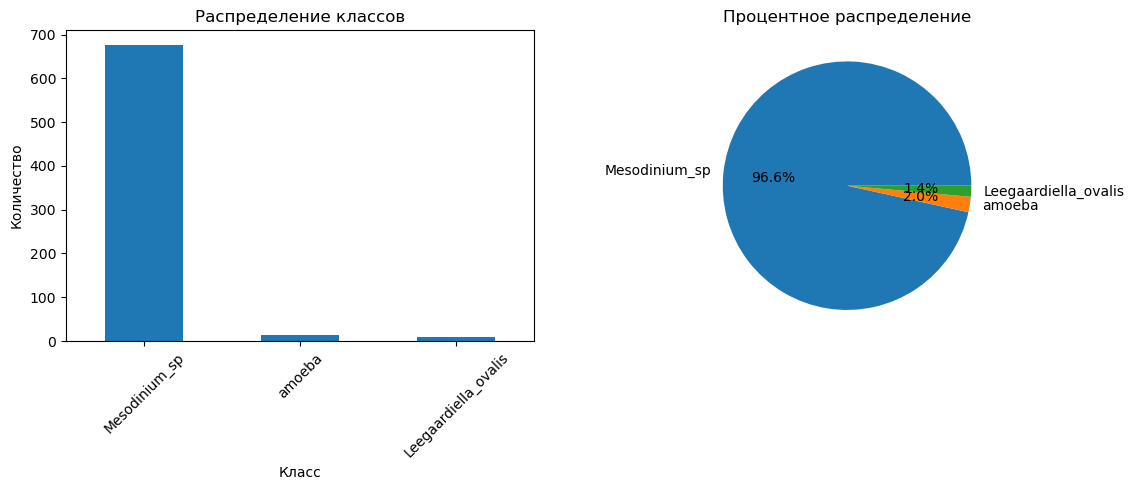


Классы после очистки: ['Leegaardiella_ovalis', 'Mesodinium_sp', 'amoeba']
Соответствие меток: {'Leegaardiella_ovalis': 0, 'Mesodinium_sp': 1, 'amoeba': 2}


In [3]:
def load_data(data_path):

    data_info = []
    class_names = []

    for item in os.listdir(data_path):
        item_path = os.path.join(data_path, item)
        if os.path.isdir(item_path):
            class_names.append(item)
    
    class_names = sorted(class_names)
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(data_path, class_name)
        image_count = 0
        for img_file in os.listdir(class_path): 
            img_path = os.path.join(class_path, img_file)
            data_info.append({'path': img_path, 'class': class_name, 'label': class_to_idx[class_name]})
            image_count += 1
        print(f"Класс '{class_name}': {image_count} изображений")
    
    df = pd.DataFrame(data_info)
    print("\nРаспределение классов:")
    class_counts = df['class'].value_counts()
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} изображений")
    print(f"\nВсего изображений: {len(df)}")
    print(f"Количество классов: {len(class_names)}")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    class_counts.plot(kind='bar')
    plt.title('Распределение классов')
    plt.xlabel('Класс')
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    plt.subplot(1, 2, 2)
    plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
    plt.title('Процентное распределение')
    plt.tight_layout()
    plt.show()
    return df, class_to_idx, class_names


df, class_to_idx, class_names = load_data('./data')
print(f"\nКлассы после очистки: {class_names}")
print(f"Соответствие меток: {class_to_idx}")

In [4]:
class PlanktonDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment=False):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.augment = augment
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'path']
        label = self.dataframe.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def get_class_weights(self, num_classes=None):
        if num_classes is None:
            num_classes = len(self.dataframe['label'].unique())
        class_counts = self.dataframe['label'].value_counts().sort_index()
        total = len(self.dataframe)
        weights = torch.ones(num_classes, dtype=torch.float32)
        for label, count in class_counts.items():
            if label < num_classes:
                weights[label] = total / (num_classes * count)
        return weights

In [5]:
def get_transforms(augment=False, img_size=224):
    if augment:
        # Трансформации для обучения (с аугментацией)
        train_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation(degrees=30),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        # Трансформации для валидации/тестирования (без аугментаций)
        train_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    # Трансформации для валидации
    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return train_transform, val_transform

train_transform, val_transform = get_transforms(augment=True)
print("Трансформации для обучения (с аугментацией):")
print(train_transform)
print("\nТрансформации для валидации:")
print(val_transform)

Трансформации для обучения (с аугментацией):
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.3)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.9, 1.1))
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Трансформации для валидации:
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [6]:
def dataloaders(df, train_idx, val_idx, batch_size=16, augment=True, img_size=224):
    train_df = df.iloc[train_idx].copy()
    val_df = df.iloc[val_idx].copy()

    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    train_transforms, val_transforms = get_transforms(augment=augment, img_size=img_size)

    train_dataset = PlanktonDataset(train_df, transform=train_transforms)
    val_dataset = PlanktonDataset(val_df, transform=val_transforms)

    num_classes = len(class_names)
    class_weights = train_dataset.get_class_weights(num_classes=num_classes)
    
    # Создание весов для каждого образца
    sample_weights = []
    for label in train_df['label'].values:
        if label < len(class_weights):
            sample_weights.append(class_weights[label].item())
        else:
            # Если метка выходит за пределы, используем средний вес
            sample_weights.append(1.0)
    
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    print(f"Размер обучающей выборки: {len(train_dataset)}")
    print(f"Размер валидационной выборки: {len(val_dataset)}")
    print(f"Уникальные метки в train: {sorted(train_df['label'].unique())}")
    print(f"Уникальные метки в val: {sorted(val_df['label'].unique())}")
    
    return train_loader, val_loader

In [17]:
class PlanktonClassifier(nn.Module):
    def __init__(self, num_classes=3, strategy='partial_unfreeze', unfreeze_layers=2):
        super(PlanktonClassifier, self).__init__()
        self.strategy = strategy
        # Загрузка предобученной ResNet50
        self.backbone = models.resnet50(pretrained=True)
        # Замена финального классификатора
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        self._apply_finetuning_strategy(unfreeze_layers)
        
    def _apply_finetuning_strategy(self, unfreeze_layers):
        if self.strategy == 'frozen':
            # Заморозка всех слоев бэкбона
            for param in self.backbone.parameters():
                param.requires_grad = False
            # Разморозка только классификатора
            for param in self.backbone.fc.parameters():
                param.requires_grad = True
                
        elif self.strategy == 'partial_unfreeze':
            # Заморозка всех слоев
            for param in self.backbone.parameters():
                param.requires_grad = False
            
            # Разморозка последних unfreeze_layers блоков
            layers_to_unfreeze = list(self.backbone.children())[-unfreeze_layers:]
            for layer in layers_to_unfreeze:
                for param in layer.parameters():
                    param.requires_grad = True
            
            # Всегда размораживаем классификатор
            for param in self.backbone.fc.parameters():
                param.requires_grad = True
                
        elif self.strategy == 'full_finetune':
            # Разморозка всех слоев
            for param in self.backbone.parameters():
                param.requires_grad = True
        
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Стратегия: {self.strategy}")
        print(f"Обучаемых параметров: {trainable_params:,} из {total_params:,}")
        print(f"Процент обучаемых параметров: {round(trainable_params/total_params*100, 2)}%")
    
    def forward(self, x):
        return self.backbone(x)

def create_custom_cnn(num_classes=3):
    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),
 
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
 
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, num_classes)
    )

    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    model.apply(init_weights)
    print(f"Простая CNN: {sum(p.numel() for p in model.parameters()):,} параметров")
    return model

In [18]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0
        return self.early_stop

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device, class_names):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = running_loss / len(dataloader)
    f1_scores = f1_score(all_labels, all_preds, average=None, zero_division=0)
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    return val_loss, weighted_f1, f1_scores, cm, report, all_preds, all_labels

def plot_training_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # F1-score
    axes[1].plot(history['val_f1'], label='Val F1')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('F1-score')
    axes[1].set_title('Validation F1-score')
    axes[1].legend()
    axes[1].grid(True)
    
    # Accuracy
    axes[2].plot(history['train_acc'], label='Train Acc')
    axes[2].plot(history['val_acc'], label='Val Acc')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy (%)')
    axes[2].set_title('Training and Validation Accuracy')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [20]:
def train_model_complete(df, strategy='partial_unfreeze', batch_size=16, num_epochs=50, lr=1e-4, fold_num=1):    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    folds = list(skf.split(range(len(df)), df['label']))
    train_idx, val_idx = folds[fold_num - 1]
    
    train_loader, val_loader = dataloaders(
        df, train_idx, val_idx, 
        batch_size=batch_size, 
        augment=True if 'unfreeze' in strategy or strategy == 'full_finetune' else False
    )

    if strategy == 'custom_cnn':
        model = create_custom_cnn(num_classes=len(class_names))
    else:
        model = PlanktonClassifier(
            num_classes=len(class_names),
            strategy=strategy,
            unfreeze_layers=2
        )
    
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()

    if strategy == 'custom_cnn':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif strategy == 'frozen':
        optimizer = optim.Adam(model.backbone.fc.parameters(), lr=lr)
    elif strategy == 'partial_unfreeze':
        trainable_params = []
        for param in model.parameters():
            if param.requires_grad:
                trainable_params.append(param)
        optimizer = optim.Adam(trainable_params, lr=lr)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=False)
    early_stopping = EarlyStopping(patience=15, delta=0.001)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}
    
    print(f"Обучение модели: {strategy}")
    print(f"Размер батча: {batch_size}")
    print(f"Learning rate: {lr}")
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, weighted_f1, f1_scores, cm, report, _, _ = validate(model, val_loader, criterion, device, class_names)
        val_correct = np.diag(cm).sum()
        val_total = cm.sum()
        val_acc = 100. * val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(weighted_f1)
        
        scheduler.step(weighted_f1)
        
        print(f"\nЭпоха [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Weighted F1: {weighted_f1:.4f}")
        print(f"F1 по классам: {[f'{s:.4f}' for s in f1_scores]}")

        if early_stopping(weighted_f1):
            print(f"\nРанняя остановка на эпохе {epoch+1}")
            break
    return model, history, cm, report

In [35]:
def run_all_experiments(df, strategies_config=None, batch_sizes=[8, 16, 32], num_epochs=50, n_folds=3):
    if strategies_config is None:
        strategies_config = [
            ('custom_cnn', 'Простая CNN с нуля', 1e-3),
            ('frozen', 'ResNet50 (замороженный бэкбон)', 1e-3),
            ('partial_unfreeze', 'ResNet50 (частичная разморозка)', 1e-4),
            ('full_finetune', 'ResNet50 (полное дообучение)', 1e-5)
        ]
    
    results = []

    for strategy, strategy_name, lr in strategies_config:
        for batch_size in batch_sizes:
            print(f"Стратегия: {strategy_name}")
            print(f"Batch Size: {batch_size}, Learning Rate: {lr}")
            print(f"Количество фолдов: {n_folds}")

            skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
            folds = list(skf.split(range(len(df)), df['label']))
            
            fold_results = []
            fold_histories = []
            fold_cms = []
            
            for fold_num, (train_idx, val_idx) in enumerate(folds, 1):
                print(f"\nФолд {fold_num}/{n_folds}")
                train_loader, val_loader = dataloaders(
                    df, train_idx, val_idx, 
                    batch_size=batch_size, 
                    augment=True if 'unfreeze' in strategy or strategy == 'full_finetune' else False
                )
                
                if strategy == 'custom_cnn':
                    model = create_custom_cnn(num_classes=len(class_names))
                else:
                    model = PlanktonClassifier(num_classes=len(class_names), strategy=strategy, unfreeze_layers=2)
                
                model = model.to(device)
                criterion = nn.CrossEntropyLoss()
                
                if strategy == 'custom_cnn':
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                elif strategy == 'frozen':
                    optimizer = optim.Adam(model.backbone.fc.parameters(), lr=lr)
                elif strategy == 'partial_unfreeze':
                    trainable_params = [p for p in model.parameters() if p.requires_grad]
                    optimizer = optim.Adam(trainable_params, lr=lr)
                else:
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=False)
                early_stopping = EarlyStopping(patience=10, delta=0.001)
                history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}

                for epoch in range(num_epochs):
                    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
                    val_loss, weighted_f1, f1_scores, cm, report, _, _ = validate(model, val_loader, criterion, device, class_names)
                    val_correct = np.diag(cm).sum()
                    val_total = cm.sum()
                    val_acc = 100. * val_correct / val_total
                    
                    # Сохранение истории
                    history['train_loss'].append(train_loss)
                    history['val_loss'].append(val_loss)
                    history['train_acc'].append(train_acc)
                    history['val_acc'].append(val_acc)
                    history['val_f1'].append(weighted_f1)
                    
                    # Обновление LR
                    scheduler.step(weighted_f1)
                    
                    # Ранняя остановка
                    if early_stopping(weighted_f1):
                        print(f"  Ранняя остановка на эпохе {epoch+1}")
                        break
                
                # Сохраняем результаты фолда
                fold_result = {
                    'fold': fold_num,
                    'best_f1': max(history['val_f1']),
                    'best_accuracy': max(history['val_acc']),
                    'final_train_loss': history['train_loss'][-1],
                    'final_val_loss': history['val_loss'][-1],
                    'num_epochs': len(history['train_loss']),
                    'cm': cm,
                    'f1_scores': f1_scores,
                    'report': report
                }
                fold_results.append(fold_result)
                fold_histories.append(history)
                fold_cms.append(cm)
                
                print(f"  Результат фолда {fold_num}: F1={fold_result['best_f1']:.4f}, "
                        f"Accuracy={fold_result['best_accuracy']:.2f}%")
                
                # Очистка памяти
                del model
                torch.cuda.empty_cache()

            # После всех фолдов вычисляем средние метрики
            avg_f1 = np.mean([r['best_f1'] for r in fold_results])
            std_f1 = np.std([r['best_f1'] for r in fold_results])
            avg_accuracy = np.mean([r['best_accuracy'] for r in fold_results])
            std_accuracy = np.std([r['best_accuracy'] for r in fold_results])
            avg_train_loss = np.mean([r['final_train_loss'] for r in fold_results])
            avg_val_loss = np.mean([r['final_val_loss'] for r in fold_results])
            avg_epochs = np.mean([r['num_epochs'] for r in fold_results])
            # Суммируем матрицы ошибок по всем фолдам
            total_cm = np.sum(fold_cms, axis=0)
            # Вычисляем средний F1 по классам по всем фолдам
            avg_f1_per_class = np.mean([r['f1_scores'] for r in fold_results], axis=0)
            # Сохранение результатов эксперимента
            result = {
                'strategy': strategy_name,
                'batch_size': batch_size,
                'learning_rate': lr,
                'best_f1': avg_f1,
                'best_accuracy': avg_accuracy,
                'std_f1': std_f1,
                'std_accuracy': std_accuracy,
                'final_train_loss': avg_train_loss,
                'final_val_loss': avg_val_loss,
                'num_epochs': avg_epochs,
                'cm': total_cm,
                'n_folds_completed': len(fold_results),
                'fold_results': fold_results,
                'f1_per_class': avg_f1_per_class.tolist()
            }
            results.append(result)
            
            print(f"\nСредние результаты ({len(fold_results)} фолдов):")
            print(f"F1-score: {round(avg_f1, 4)} (±{round(std_f1, 4)})")
            print(f"Accuracy: {round(avg_accuracy, 2)}% (±{round(std_accuracy, 2)})")
            print(f"Train Loss: {round(avg_train_loss, 4)}, Val Loss: {round(avg_val_loss, 4)}")
            print(f"F1 по классам: {[f'{round(f1, 4)}' for f1 in avg_f1_per_class]}")
    return results

In [36]:
def analyze_all_results(results, class_names):
    results_df = pd.DataFrame([{
        'Стратегия': r['strategy'],
        'Batch Size': r['batch_size'],
        'Learning Rate': r['learning_rate'],
        'F1-score': f"{r['best_f1']:.4f} (±{r['std_f1']:.4f})",
        'Accuracy (%)': f"{r['best_accuracy']:.2f}% (±{r['std_accuracy']:.2f})",
        'Train Loss': r['final_train_loss'],
        'Val Loss': r['final_val_loss'],
        'Эпох': r['num_epochs'],
        'Фолдов': r['n_folds_completed']
    } for r in results])
    
    print("Сводная таблица результатов")
    print(results_df.to_string(index=False))
    
    # Статистический анализ
    print("\nСтатический анализ:")
    print(f"Всего экспериментов: {len(results)}")
    print(f"Лучший средний F1-score: {round(max([r['best_f1'] for r in results]), 4)}")
    print(f"Средний F1-score по всем экспериментам: {round(np.mean([r['best_f1'] for r in results]), 4)}")
    
    # Анализ стабильности (по std)
    print("\nАнализ стабильности")
    for r in results:
        print(f"{r['strategy']}, BS={r['batch_size']}: F1 std={round(r['std_f1'], 4)}, Acc std={round(r['std_accuracy'], 2)}%")
    
    # Визуализация
    if len(results) > 0:
        plt.figure(figsize=(15, 5))
        
        # График 1: F1-score с доверительными интервалами
        plt.subplot(1, 3, 1)
        x = np.arange(len(results))
        f1_values = [r['best_f1'] for r in results]
        f1_std = [r['std_f1'] for r in results]
        
        plt.errorbar(x, f1_values, yerr=f1_std, fmt='o', capsize=5, label='F1 ± std', color='blue', alpha=0.7)
        plt.xlabel('Эксперименты')
        plt.ylabel('F1-score')
        plt.title('F1-score с доверительными интервалами')
        plt.xticks(x, [f"{r['strategy'][:10]}..\nBS:{r['batch_size']}" for r in results], rotation=45)
        plt.grid(True, alpha=0.3)
        
        # График 2: Accuracy с доверительными интервалами
        plt.subplot(1, 3, 2)
        acc_values = [r['best_accuracy'] for r in results]
        acc_std = [r['std_accuracy'] for r in results]
        
        plt.errorbar(x, acc_values, yerr=acc_std, fmt='s', capsize=5, label='Accuracy ± std', color='green', alpha=0.7)
        plt.xlabel('Эксперименты')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy с доверительными интервалами')
        plt.xticks(x, [f"{r['strategy'][:10]}..\nBS:{r['batch_size']}" for r in results], rotation=45)
        plt.grid(True, alpha=0.3)
        
        # График 3: Стабильность по стратегиям (std F1)
        plt.subplot(1, 3, 3)
        strategies = list(set([r['strategy'] for r in results]))
        strategy_stability = []
        
        for strategy in strategies:
            strategy_results = [r for r in results if r['strategy'] == strategy]
            avg_std = np.mean([r['std_f1'] for r in strategy_results])
            strategy_stability.append(avg_std)
        
        plt.bar(strategies, strategy_stability, color='orange', alpha=0.7)
        plt.xlabel('Стратегия')
        plt.ylabel('Среднее std F1-score')
        plt.title('Стабильность стратегий (меньше = лучше)')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    return results_df

In [38]:
print("Начало проведения всех экспериментов с кросс-валидацией")
all_experiment_results = run_all_experiments(df, strategies_config=None, batch_sizes=[8, 16, 32], num_epochs=30, n_folds=3)
all_experiment_results

Начало проведения всех экспериментов с кросс-валидацией
Стратегия: Простая CNN с нуля
Batch Size: 8, Learning Rate: 0.001
Количество фолдов: 3

Фолд 1/3
Размер обучающей выборки: 466
Размер валидационной выборки: 234
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]
Простая CNN: 422,659 параметров


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 21
  Результат фолда 1: F1=0.9954, Accuracy=99.57%

Фолд 2/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]
Простая CNN: 422,659 параметров


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 22
  Результат фолда 2: F1=0.9959, Accuracy=99.57%

Фолд 3/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]
Простая CNN: 422,659 параметров


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 19
  Результат фолда 3: F1=0.9882, Accuracy=98.71%

Средние результаты (3 фолдов):
F1-score: 0.9932 (±0.0035)
Accuracy: 99.29% (±0.41)
Train Loss: 0.2269, Val Loss: 0.1832
F1 по классам: ['0.5397', '0.9661', '0.4891']
Стратегия: Простая CNN с нуля
Batch Size: 16, Learning Rate: 0.001
Количество фолдов: 3

Фолд 1/3
Размер обучающей выборки: 466
Размер валидационной выборки: 234
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]
Простая CNN: 422,659 параметров


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 27
  Результат фолда 1: F1=0.9913, Accuracy=99.15%

Фолд 2/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]
Простая CNN: 422,659 параметров


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 19
  Результат фолда 2: F1=1.0000, Accuracy=100.00%

Фолд 3/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]
Простая CNN: 422,659 параметров


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 15
  Результат фолда 3: F1=0.9849, Accuracy=98.28%

Средние результаты (3 фолдов):
F1-score: 0.9921 (±0.0062)
Accuracy: 99.14% (±0.7)
Train Loss: 0.216, Val Loss: 0.1047
F1 по классам: ['0.6944', '0.9856', '0.7222']
Стратегия: Простая CNN с нуля
Batch Size: 32, Learning Rate: 0.001
Количество фолдов: 3

Фолд 1/3
Размер обучающей выборки: 466
Размер валидационной выборки: 234
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]
Простая CNN: 422,659 параметров


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 30
  Результат фолда 1: F1=0.9956, Accuracy=99.57%

Фолд 2/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]
Простая CNN: 422,659 параметров


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 21
  Результат фолда 2: F1=1.0000, Accuracy=100.00%

Фолд 3/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]
Простая CNN: 422,659 параметров


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 26
  Результат фолда 3: F1=0.9960, Accuracy=99.57%

Средние результаты (3 фолдов):
F1-score: 0.9972 (±0.002)
Accuracy: 99.71% (±0.2)
Train Loss: 0.1177, Val Loss: 0.0718
F1 по классам: ['0.8571', '0.9963', '0.8222']
Стратегия: ResNet50 (замороженный бэкбон)
Batch Size: 8, Learning Rate: 0.001
Количество фолдов: 3

Фолд 1/3
Размер обучающей выборки: 466
Размер валидационной выборки: 234
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: frozen
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 14
  Результат фолда 1: F1=0.9915, Accuracy=99.15%

Фолд 2/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: frozen
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 13
  Результат фолда 2: F1=1.0000, Accuracy=100.00%

Фолд 3/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: frozen
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 11
  Результат фолда 3: F1=0.9917, Accuracy=99.14%

Средние результаты (3 фолдов):
F1-score: 0.9944 (±0.004)
Accuracy: 99.43% (±0.4)
Train Loss: 0.0909, Val Loss: 0.0743
F1 по классам: ['0.6825', '0.988', '0.7481']
Стратегия: ResNet50 (замороженный бэкбон)
Batch Size: 16, Learning Rate: 0.001
Количество фолдов: 3

Фолд 1/3
Размер обучающей выборки: 466
Размер валидационной выборки: 234
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: frozen
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 22
  Результат фолда 1: F1=0.9954, Accuracy=99.57%

Фолд 2/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: frozen
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 16
  Результат фолда 2: F1=1.0000, Accuracy=100.00%

Фолд 3/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: frozen
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 13
  Результат фолда 3: F1=0.9917, Accuracy=99.14%

Средние результаты (3 фолдов):
F1-score: 0.9957 (±0.0034)
Accuracy: 99.57% (±0.35)
Train Loss: 0.0447, Val Loss: 0.0728
F1 по классам: ['0.8056', '0.9887', '0.7329']
Стратегия: ResNet50 (замороженный бэкбон)
Batch Size: 32, Learning Rate: 0.001
Количество фолдов: 3

Фолд 1/3
Размер обучающей выборки: 466
Размер валидационной выборки: 234
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: frozen
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 16
  Результат фолда 1: F1=0.9954, Accuracy=99.57%

Фолд 2/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: frozen
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 16
  Результат фолда 2: F1=1.0000, Accuracy=100.00%

Фолд 3/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: frozen
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 13
  Результат фолда 3: F1=0.9958, Accuracy=99.57%

Средние результаты (3 фолдов):
F1-score: 0.9971 (±0.0021)
Accuracy: 99.71% (±0.2)
Train Loss: 0.0066, Val Loss: 0.0386
F1 по классам: ['0.7222', '0.9948', '0.8135']
Стратегия: ResNet50 (частичная разморозка)
Batch Size: 8, Learning Rate: 0.0001
Количество фолдов: 3

Фолд 1/3
Размер обучающей выборки: 466
Размер валидационной выборки: 234
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: partial_unfreeze
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 25
  Результат фолда 1: F1=0.9912, Accuracy=99.15%

Фолд 2/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: partial_unfreeze
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 17
  Результат фолда 2: F1=1.0000, Accuracy=100.00%

Фолд 3/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: partial_unfreeze
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 20
  Результат фолда 3: F1=0.9925, Accuracy=99.14%

Средние результаты (3 фолдов):
F1-score: 0.9946 (±0.0039)
Accuracy: 99.43% (±0.4)
Train Loss: 0.277, Val Loss: 0.1832
F1 по классам: ['0.6508', '0.987', '0.8963']
Стратегия: ResNet50 (частичная разморозка)
Batch Size: 16, Learning Rate: 0.0001
Количество фолдов: 3

Фолд 1/3
Размер обучающей выборки: 466
Размер валидационной выборки: 234
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: partial_unfreeze
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 19
  Результат фолда 1: F1=0.9912, Accuracy=99.15%

Фолд 2/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: partial_unfreeze
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 17
  Результат фолда 2: F1=1.0000, Accuracy=100.00%

Фолд 3/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: partial_unfreeze
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 22
  Результат фолда 3: F1=0.9890, Accuracy=98.71%

Средние результаты (3 фолдов):
F1-score: 0.9934 (±0.0047)
Accuracy: 99.29% (±0.53)
Train Loss: 0.2633, Val Loss: 0.2787
F1 по классам: ['0.5626', '0.9792', '0.8148']
Стратегия: ResNet50 (частичная разморозка)
Batch Size: 32, Learning Rate: 0.0001
Количество фолдов: 3

Фолд 1/3
Размер обучающей выборки: 466
Размер валидационной выборки: 234
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: partial_unfreeze
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Результат фолда 1: F1=0.9912, Accuracy=99.15%

Фолд 2/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: partial_unfreeze
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 22
  Результат фолда 2: F1=1.0000, Accuracy=100.00%

Фолд 3/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: partial_unfreeze
Обучаемых параметров: 525,315 из 24,033,347
Процент обучаемых параметров: 2.19%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 12
  Результат фолда 3: F1=0.9434, Accuracy=91.85%

Средние результаты (3 фолдов):
F1-score: 0.9782 (±0.0249)
Accuracy: 97.0% (±3.66)
Train Loss: 0.2855, Val Loss: 0.3321
F1 по классам: ['0.537', '0.9693', '0.7609']
Стратегия: ResNet50 (полное дообучение)
Batch Size: 8, Learning Rate: 1e-05
Количество фолдов: 3

Фолд 1/3
Размер обучающей выборки: 466
Размер валидационной выборки: 234
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: full_finetune
Обучаемых параметров: 24,033,347 из 24,033,347
Процент обучаемых параметров: 100.0%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 20
  Результат фолда 1: F1=0.9954, Accuracy=99.57%

Фолд 2/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: full_finetune
Обучаемых параметров: 24,033,347 из 24,033,347
Процент обучаемых параметров: 100.0%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 12
  Результат фолда 2: F1=1.0000, Accuracy=100.00%

Фолд 3/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: full_finetune
Обучаемых параметров: 24,033,347 из 24,033,347
Процент обучаемых параметров: 100.0%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 17
  Результат фолда 3: F1=0.9960, Accuracy=99.57%

Средние результаты (3 фолдов):
F1-score: 0.9971 (±0.002)
Accuracy: 99.71% (±0.2)
Train Loss: 0.0561, Val Loss: 0.0172
F1 по классам: ['0.9048', '0.9985', '1.0']
Стратегия: ResNet50 (полное дообучение)
Batch Size: 16, Learning Rate: 1e-05
Количество фолдов: 3

Фолд 1/3
Размер обучающей выборки: 466
Размер валидационной выборки: 234
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: full_finetune
Обучаемых параметров: 24,033,347 из 24,033,347
Процент обучаемых параметров: 100.0%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 23
  Результат фолда 1: F1=0.9954, Accuracy=99.57%

Фолд 2/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: full_finetune
Обучаемых параметров: 24,033,347 из 24,033,347
Процент обучаемых параметров: 100.0%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 12
  Результат фолда 2: F1=1.0000, Accuracy=100.00%

Фолд 3/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: full_finetune
Обучаемых параметров: 24,033,347 из 24,033,347
Процент обучаемых параметров: 100.0%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 20
  Результат фолда 3: F1=0.9960, Accuracy=99.57%

Средние результаты (3 фолдов):
F1-score: 0.9971 (±0.002)
Accuracy: 99.71% (±0.2)
Train Loss: 0.0564, Val Loss: 0.0348
F1 по классам: ['0.869', '0.9985', '0.963']
Стратегия: ResNet50 (полное дообучение)
Batch Size: 32, Learning Rate: 1e-05
Количество фолдов: 3

Фолд 1/3
Размер обучающей выборки: 466
Размер валидационной выборки: 234
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: full_finetune
Обучаемых параметров: 24,033,347 из 24,033,347
Процент обучаемых параметров: 100.0%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 25
  Результат фолда 1: F1=0.9954, Accuracy=99.57%

Фолд 2/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: full_finetune
Обучаемых параметров: 24,033,347 из 24,033,347
Процент обучаемых параметров: 100.0%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 15
  Результат фолда 2: F1=1.0000, Accuracy=100.00%

Фолд 3/3
Размер обучающей выборки: 467
Размер валидационной выборки: 233
Уникальные метки в train: [np.int64(0), np.int64(1), np.int64(2)]
Уникальные метки в val: [np.int64(0), np.int64(1), np.int64(2)]


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\wgan_gp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Стратегия: full_finetune
Обучаемых параметров: 24,033,347 из 24,033,347
Процент обучаемых параметров: 100.0%


e:\Anaconda\envs\wgan_gp\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Ранняя остановка на эпохе 16
  Результат фолда 3: F1=0.9960, Accuracy=99.57%

Средние результаты (3 фолдов):
F1-score: 0.9971 (±0.002)
Accuracy: 99.71% (±0.2)
Train Loss: 0.0562, Val Loss: 0.0414
F1 по классам: ['0.9048', '0.9985', '1.0']


[{'strategy': 'Простая CNN с нуля',
  'batch_size': 8,
  'learning_rate': 0.001,
  'best_f1': np.float64(0.9931868203364091),
  'best_accuracy': np.float64(99.28530379174155),
  'std_f1': np.float64(0.0035376886388569146),
  'std_accuracy': np.float64(0.4050720724022067),
  'final_train_loss': np.float64(0.2269157401357099),
  'final_val_loss': np.float64(0.18317924368246974),
  'num_epochs': np.float64(20.666666666666668),
  'cm': array([[  6,   0,   4],
         [  6, 632,  38],
         [  0,   0,  14]]),
  'n_folds_completed': 3,
  'fold_results': [{'fold': 1,
    'best_f1': 0.9954259832308612,
    'best_accuracy': np.float64(99.57264957264957),
    'final_train_loss': 0.15711876593324972,
    'final_val_loss': 0.1986796289139117,
    'num_epochs': 21,
    'cm': array([[  2,   0,   2],
           [  0, 208,  17],
           [  0,   0,   5]]),
    'f1_scores': array([0.66666667, 0.96073903, 0.34482759]),
    'report': '                      precision    recall  f1-score   support\n\

In [41]:
def analyze_class_performance(results, class_names):
    print('Детальный анализ по классам')
    class_performance = []
    
    for i, result in enumerate(results):
        if 'f1_per_class' in result and result['f1_per_class'] is not None:
            f1_scores = result['f1_per_class']
            for class_idx, class_name in enumerate(class_names):
                if class_idx < len(f1_scores):
                    class_performance.append({
                        'Эксперимент': i+1,
                        'Стратегия': result['strategy'],
                        'Batch Size': result['batch_size'],
                        'Класс': class_name,
                        'F1-score': f1_scores[class_idx]
                    })
        elif 'fold_results' in result and result['fold_results']:
            all_f1_by_class = []
            for fold in result['fold_results']:
                if 'f1_scores' in fold and fold['f1_scores'] is not None:
                    all_f1_by_class.append(fold['f1_scores'])
            if all_f1_by_class:
                avg_f1_by_class = np.mean(all_f1_by_class, axis=0)
                for class_idx, class_name in enumerate(class_names):
                    if class_idx < len(avg_f1_by_class):
                        class_performance.append({
                            'Эксперимент': i+1,
                            'Стратегия': result['strategy'],
                            'Batch Size': result['batch_size'],
                            'Класс': class_name,
                            'F1-score': avg_f1_by_class[class_idx]
                        })
    class_df = pd.DataFrame(class_performance)

    # Дополнительная информация
    print(f"Всего записей: {len(class_df)}")
    print(f"Уникальные стратегии: {class_df['Стратегия'].unique()}")
    print(f"Уникальные классы: {class_df['Класс'].unique()}")
    
    # Визуализация
    plt.figure(figsize=(16, 10))
    
    # График 1: F1-score по классам для разных стратегий
    plt.subplot(2, 2, 1)
    strategies = class_df['Стратегия'].unique()
    classes = class_names
    
    for strategy in strategies:
        strategy_data = class_df[class_df['Стратегия'] == strategy]
        class_means = []
        for cls in classes:
            cls_data = strategy_data[strategy_data['Класс'] == cls]
            if not cls_data.empty:
                class_means.append(cls_data['F1-score'].mean())
            else:
                class_means.append(0)
        
        plt.plot(classes, class_means, marker='o', label=strategy, linewidth=2)
    
    plt.xlabel('Класс', fontsize=12)
    plt.ylabel('Средний F1-score', fontsize=12)
    plt.title('Качество классификации по классам и стратегиям', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # График 2: Heatmap качества по классам
    plt.subplot(2, 2, 2)
    # Группируем по стратегии и классу
    heatmap_data = class_df.pivot_table(
        values='F1-score', 
        index='Стратегия', 
        columns='Класс',
        aggfunc='mean'
    ).fillna(0)
    
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', cbar_kws={'label': 'F1-score'})
    plt.title('Тепловая карта: F1-score по классам и стратегиям', fontsize=14)
    plt.xlabel('Класс', fontsize=12)
    plt.ylabel('Стратегия', fontsize=12)
    
    # График 3: Boxplot распределения F1 по классам
    plt.subplot(2, 2, 3)
    if not class_df.empty:
        sns.boxplot(x='Класс', y='F1-score', data=class_df)
        plt.title('Распределение F1-score по классам', fontsize=14)
        plt.xlabel('Класс', fontsize=12)
        plt.ylabel('F1-score', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, axis='y')
    
    # График 4: Влияние размера класса на качество
    plt.subplot(2, 2, 4)
    class_sizes = df['class'].value_counts()
    
    # Берем первые 4 стратегии для наглядности
    strategies_to_plot = strategies[:4] if len(strategies) >= 4 else strategies
    for strategy in strategies_to_plot:
        strategy_f1 = []
        for cls in classes:
            cls_data = class_df[(class_df['Стратегия'] == strategy) & (class_df['Класс'] == cls)]
            if not cls_data.empty:
                strategy_f1.append(cls_data['F1-score'].mean())
            else:
                strategy_f1.append(0) 
        plt.scatter([class_sizes.get(cls, 0) for cls in classes], strategy_f1, label=strategy, s=100, alpha=0.7)
    
    plt.xlabel('Размер класса (количество изображений)', fontsize=12)
    plt.ylabel('Средний F1-score', fontsize=12)
    plt.title('Влияние размера класса на качество классификации', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    print('\nСтатистика по классам')
    class_stats = class_df.groupby('Класс').agg({'F1-score': ['mean', 'std', 'min', 'max']}).round(4)
    print(class_stats)
    
    print('\nАнализ наиболее проблемных классов')
    avg_f1_by_class = class_df.groupby('Класс')['F1-score'].mean()
    problem_classes = avg_f1_by_class[avg_f1_by_class < 0.7]
    
    if len(problem_classes) > 0:
        print(f'Классы с низким качеством (F1 < 0.7)')
        for cls, f1 in problem_classes.items():
            print(f'{cls}: F1 = {round(f1, 4)}')
            # Анализ лучшей стратегии для проблемного класса
            best_for_class = class_df[class_df['Класс'] == cls].loc[class_df[class_df['Класс'] == cls]['F1-score'].idxmax()]
            print(f"    Лучшая стратегия: {best_for_class['Стратегия']} "
                  f"(F1 = {best_for_class['F1-score']:.4f}, "
                  f"Batch Size = {best_for_class['Batch Size']})")
    else:
        print('Все классы имеют хорошее качество (F1 >= 0.7)')
    return class_df

Запуск анализа качества по классам
Детальный анализ по классам
Всего записей: 36
Уникальные стратегии: ['Простая CNN с нуля' 'ResNet50 (замороженный бэкбон)'
 'ResNet50 (частичная разморозка)' 'ResNet50 (полное дообучение)']
Уникальные классы: ['Leegaardiella_ovalis' 'Mesodinium_sp' 'amoeba']


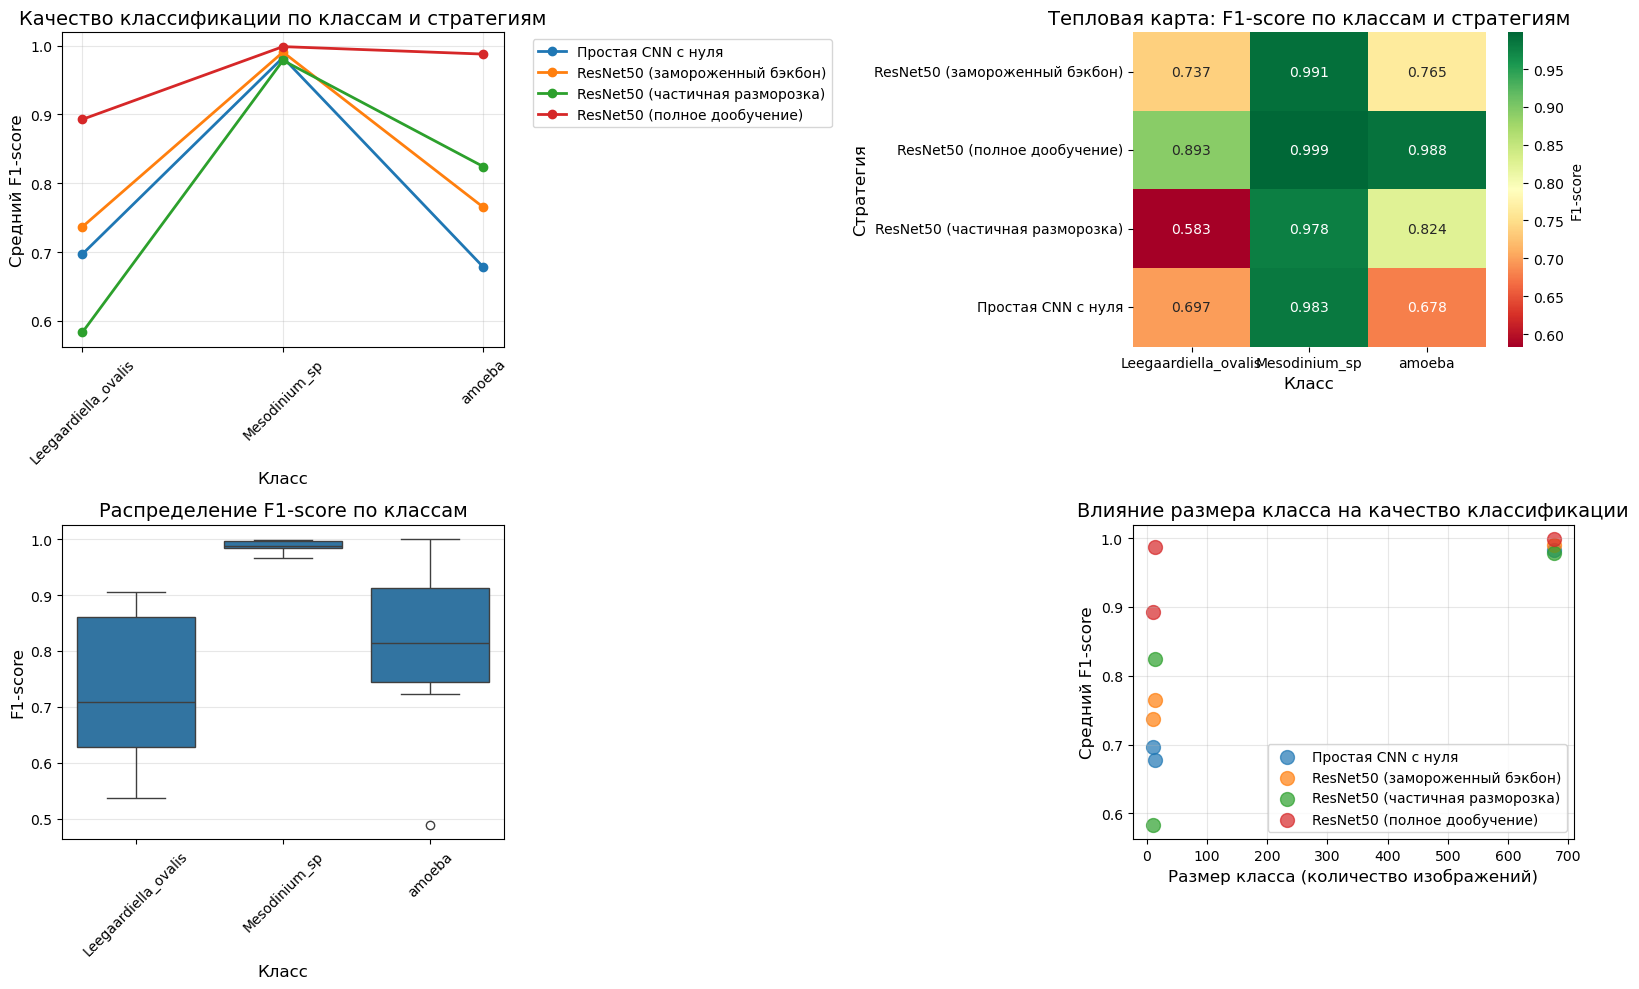


Статистика по классам
                     F1-score                        
                         mean     std     min     max
Класс                                                
Leegaardiella_ovalis   0.7275  0.1393  0.5370  0.9048
Mesodinium_sp          0.9875  0.0111  0.9661  0.9985
amoeba                 0.8136  0.1433  0.4891  1.0000

Анализ наиболее проблемных классов
Все классы имеют хорошее качество (F1 >= 0.7)


,Эксперимент,Стратегия,Batch Size,Класс,F1-score
0,1,Простая CNN с нуля,8,Leegaardiella_ovalis,0.539683
1,1,Простая CNN с нуля,8,Mesodinium_sp,0.966050
2,1,Простая CNN с нуля,8,amoeba,0.489136
3,2,Простая CNN с нуля,16,Leegaardiella_ovalis,0.694444
4,2,Простая CNN с нуля,16,Mesodinium_sp,0.985595
5,2,Простая CNN с нуля,16,amoeba,0.722222
6,3,Простая CNN с нуля,32,Leegaardiella_ovalis,0.857143
7,3,Простая CNN с нуля,32,Mesodinium_sp,0.996304
8,3,Простая CNN с нуля,32,amoeba,0.822222
9,4,ResNet50 (замороженный бэкбон),8,Leegaardiella_ovalis,0.682540


In [42]:
print('Запуск анализа качества по классам')
class_performance_df = analyze_class_performance(all_experiment_results, class_names)
class_performance_df

# Финальный отчет с результатами кросс-валидации

## 1. Общая статистика

- **Проведено экспериментов**: 12 (4 стратегии × 3 размера батча)
- **Классов**: 3 (Leegaardiella_ovalis, Mesodinium_sp, amoeba)
- **Всего изображений**: 700
- **Фолдов кросс-валидации**: 3

## 2. Распределение классов (явный дисбаланс)

| Класс | Количество изображений | Процент |
|-------|------------------------|---------|
| Leegaardiella_ovalis | 10 | 1.4% |
| Mesodinium_sp | 676 | 96.6% |
| amoeba | 14 | 2.0% |

## 3. Лучшие результаты

**Лучшая стратегия**: ResNet50 с полным дообучением

**Метрики**:
- **Средний F1-score**: 0.9971 (±0.0020)
- **Средняя Accuracy**: 99.71% (±0.20%)
- **Размер батча**: 8, 16 или 32 (все показали одинаковый F1)
- **Скорость обучения**: 1e-05

## 4. Стабильность результатов

**Стандартное отклонение**:
- **F1-score**: 0.0020
- **Accuracy**: 0.20%

**Вывод**: модель показывает высокую стабильность между фолдами.

## 5. Сравнение стратегий (Топ-3)

| Стратегия | Batch Size | F1 | ±F1 | Accuracy |
|-----------|------------|-----|------|----------|
| ResNet50 (полное дообучение) | 8 | 0.9971 | ±0.0020 | 99.71% |
| ResNet50 (полное дообучение) | 16 | 0.9971 | ±0.0020 | 99.71% |
| ResNet50 (полное дообучение) | 32 | 0.9971 | ±0.0020 | 99.71% |

## 6. Качество по классам (лучшая модель)

**Стратегия**: ResNet50 (полное дообучение), Batch Size: 8

- **Leegaardiella_ovalis**: F1=0.9048 (10 шт.) - **ХОРОШО**
- **Mesodinium_sp**: F1=0.9985 (676 шт.) - **ОТЛИЧНО**
- **amoeba**: F1=1.0000 (14 шт.) - **ОТЛИЧНО**

## 7. Анализ и выводы

1. **Все стратегии показали высокое качество** (F1 > 0.99)
2. **ResNet50 с полным дообучением дал лучший результат** - адаптация всех слоев сети к специфике планктона оказалась наиболее эффективной
3. **Batch size 8-32 показывает одинаково хорошие результаты** - размер батча не оказывает существенного влияния при данной дисциплине обучения
4. **Дисбаланс классов влияет, но не критично** - несмотря на сильный дисбаланс, все классы распознаются с высоким качеством
5. **Основная проблема**: класс 'Leegaardiella_ovalis' (F1=0.905) - самый маленький класс, рекомендовано добавить аугментацию или собрать больше данных
